<a href="https://www.kaggle.com/code/dsptlp/canada-consumer-price-index-forecast-using-prophet?scriptVersionId=167823150" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.dates as mdates
import requests

from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.plot import add_changepoints_to_plot

import warnings
warnings.filterwarnings('ignore')

In [2]:
def download_csv(url, destination):
    response = requests.get(url)
    with open(destination, 'wb') as file:
        file.write(response.content)

csv_url = 'https://www150.statcan.gc.ca/t1/tbl1/en/dtl!downloadDbLoadingData-nonTraduit.action?pid=1810000401&latestN=0&startDate=20001001&endDate=20240201&csvLocale=en&selectedMembers=%5B%5B2%5D%2C%5B2%2C3%2C79%2C96%2C139%2C176%2C184%2C201%2C219%2C256%2C274%2C282%2C285%2C287%2C288%5D%5D&checkedLevels='
destination_path = 'data_file.csv'

download_csv(csv_url, destination_path)

In [3]:
df = pd.read_csv(destination_path, encoding='utf-8')
df.head(5)

,REF_DATE,GEO,DGUID,Products and product groups,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2000-10,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,96.3,NaN,NaN,NaN,1
1,2000-11,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,96.6,NaN,NaN,NaN,1
2,2000-12,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,96.7,NaN,NaN,NaN,1
3,2001-01,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,96.3,NaN,NaN,NaN,1
4,2001-02,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,96.8,NaN,NaN,NaN,1


In [4]:
df = df.rename(columns={"REF_DATE": "ds", "VALUE": "y"})
df = df[df['Products and product groups'] == 'All-items']

df['ds'] = pd.to_datetime(df['ds'])
df['ds'] = df['ds'] + pd.offsets.MonthEnd(0)
df.tail(5)

,ds,GEO,DGUID,Products and product groups,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,y,STATUS,SYMBOL,TERMINATED,DECIMALS
276,2023-10-31,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,158.6,NaN,NaN,NaN,1
277,2023-11-30,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,158.8,NaN,NaN,NaN,1
278,2023-12-31,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,158.3,NaN,NaN,NaN,1
279,2024-01-31,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,158.3,NaN,NaN,NaN,1
280,2024-02-29,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,158.8,NaN,NaN,NaN,1


15:17:59 - cmdstanpy - INFO - Chain [1] start processing
15:17:59 - cmdstanpy - INFO - Chain [1] done processing


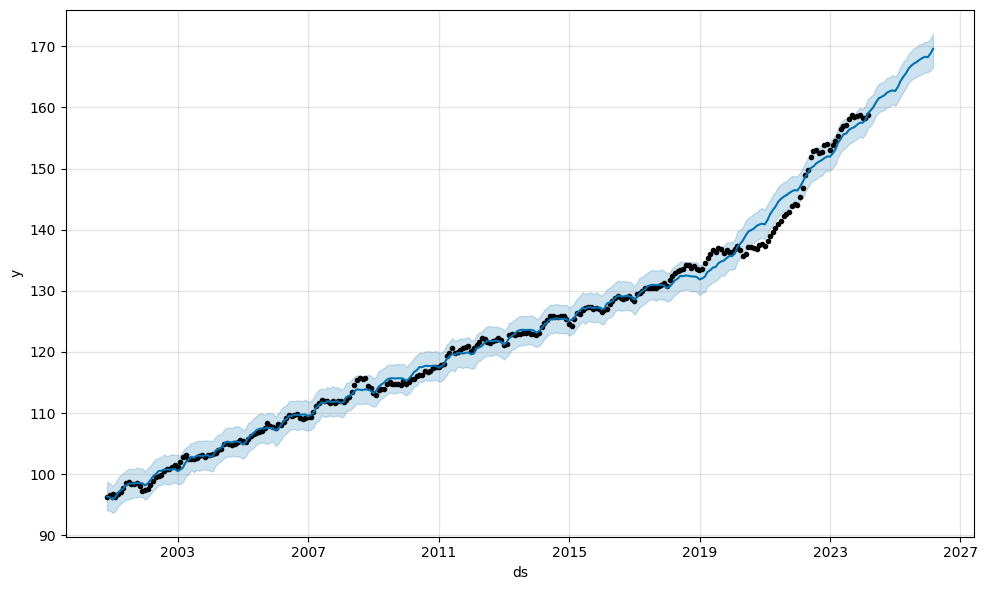

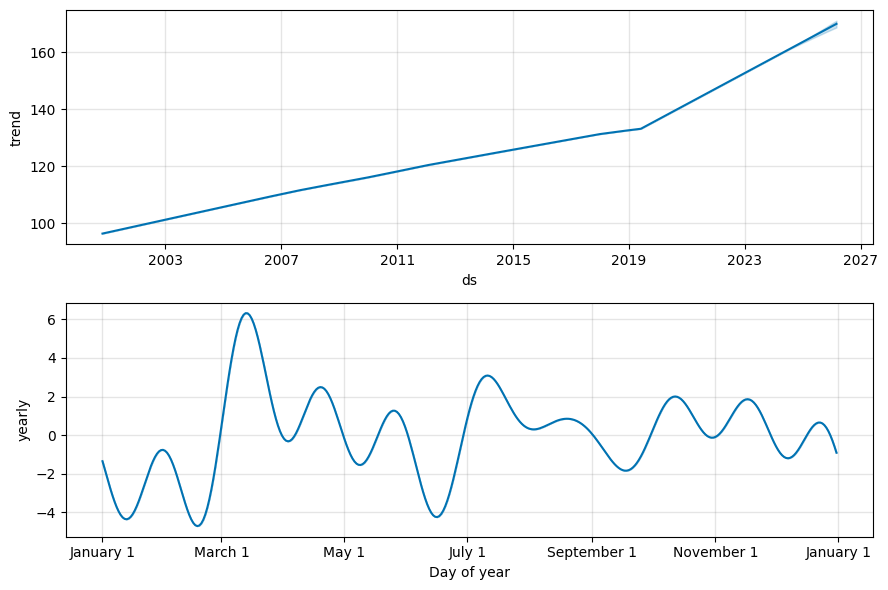

In [5]:
my_model = Prophet(interval_width=0.95,daily_seasonality=False)
my_model.fit(df)

future_dates = my_model.make_future_dataframe(periods=24 , freq = 'ME' , include_history = 'TRUE')
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

fig1 = my_model.plot(forecast)
fig2 = my_model.plot_components(forecast)

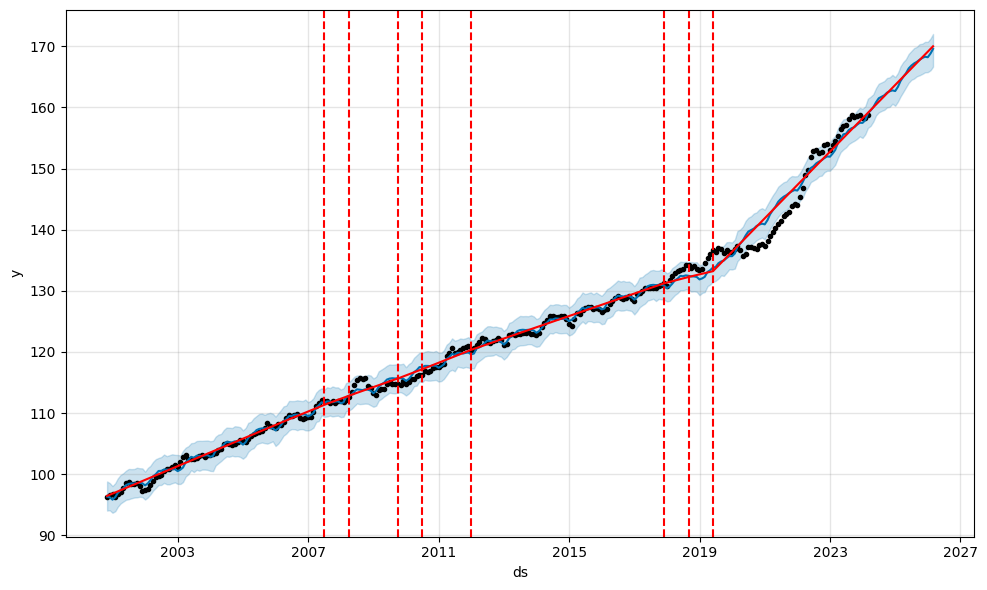

In [6]:
fig = my_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), my_model, forecast)

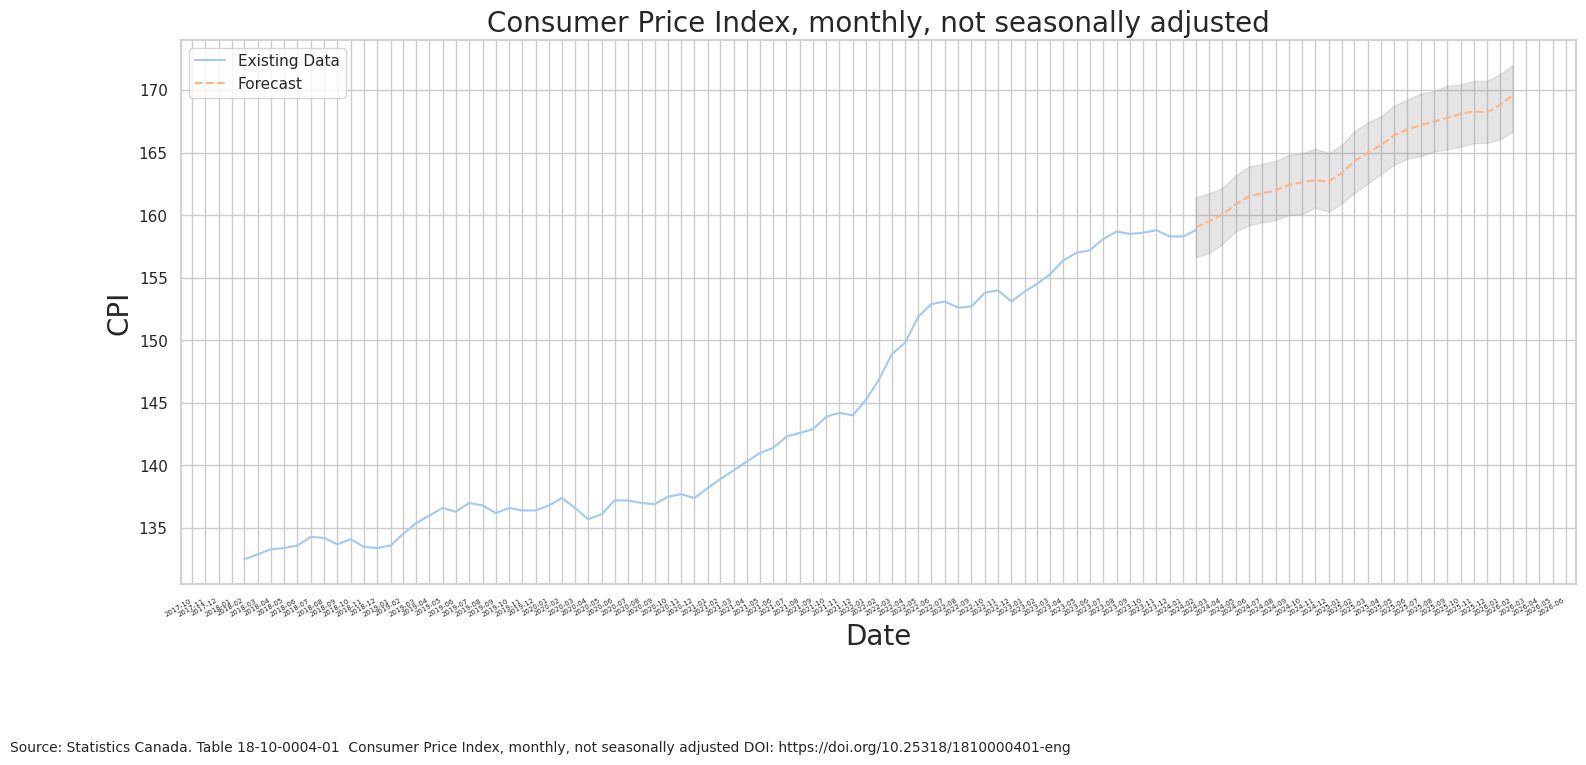

In [7]:
forecast_plot = forecast[(forecast['ds'] > '01/31/2024') ]
forecast_plot = forecast_plot[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

existing_data = df[['ds', 'y']]
existing_data = existing_data[existing_data['ds'] > '01/31/2018']

# Merge the existing data with the forecast on 'ds'
merged_data = pd.merge(existing_data, forecast_plot, on='ds', how='outer')

sns.set(style="whitegrid", font_scale=1)
sns.set_palette("pastel")  # Choose a light color palette

# Plot the existing data
plt.figure(figsize=(18, 8))
sns.lineplot(x='ds', y='y', data=merged_data, label='Existing Data')

# Plot the forecast
sns.lineplot(x='ds', y='yhat', data=merged_data, label='Forecast', linestyle='dashed')

# Fill the confidence interval
plt.fill_between(merged_data['ds'], merged_data['yhat_lower'], merged_data['yhat_upper'], color='gray', alpha=0.2)

# Specify the frequency of the x-axis labels (e.g., every 2 months)
locator = mdates.MonthLocator(bymonthday=-1, interval=1)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate x-axis labels for better readability
plt.gcf().autofmt_xdate()

# Set x-axis label font size
plt.xticks(fontsize=5)

plt.title('Consumer Price Index, monthly, not seasonally adjusted', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('CPI', fontsize=20)
plt.legend()


footnote_text = "Source: Statistics Canada. Table 18-10-0004-01  Consumer Price Index, monthly, not seasonally adjusted DOI: https://doi.org/10.25318/1810000401-eng"
plt.figtext(0.03, -0.01, footnote_text, ha="left", fontsize=10, bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))    

fig.savefig('CPI.png',transparent=True,  bbox_inches='tight',pad_inches=0.15,dpi=400)

plt.show()

In [8]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-10-31,96.437334,94.035091,98.802675,96.437334,96.437334,-0.118350,-0.118350,-0.118350,-0.118350,-0.118350,-0.118350,0.0,0.0,0.0,96.318984
1,2000-11-30,96.622184,94.081663,98.532225,96.622184,96.622184,-0.422196,-0.422196,-0.422196,-0.422196,-0.422196,-0.422196,0.0,0.0,0.0,96.199988
2,2000-12-31,96.813195,93.675256,98.041534,96.813195,96.813195,-0.992735,-0.992735,-0.992735,-0.992735,-0.992735,-0.992735,0.0,0.0,0.0,95.820459
3,2001-01-31,97.004206,93.933153,98.527559,97.004206,97.004206,-0.759242,-0.759242,-0.759242,-0.759242,-0.759242,-0.759242,0.0,0.0,0.0,96.244964
4,2001-02-28,97.176732,94.645967,99.294485,97.176732,97.176732,-0.248828,-0.248828,-0.248828,-0.248828,-0.248828,-0.248828,0.0,0.0,0.0,96.927905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,2025-10-31,168.213070,165.485534,170.433789,167.263371,169.046243,-0.124323,-0.124323,-0.124323,-0.124323,-0.124323,-0.124323,0.0,0.0,0.0,168.088747
301,2025-11-30,168.660935,165.741194,170.729938,167.630951,169.581589,-0.368943,-0.368943,-0.368943,-0.368943,-0.368943,-0.368943,0.0,0.0,0.0,168.291992
302,2025-12-31,169.123729,165.778744,170.731816,168.013647,170.130796,-0.907239,-0.907239,-0.907239,-0.907239,-0.907239,-0.907239,0.0,0.0,0.0,168.216491
303,2026-01-31,169.586524,166.082530,171.278887,168.396343,170.656479,-0.757214,-0.757214,-0.757214,-0.757214,-0.757214,-0.757214,0.0,0.0,0.0,168.829310
